# Decent Logger: An Activity Positioning Prediction System

Import Statements

In [57]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from collections import OrderedDict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import kurtosis, skew, iqr, variation
from statsmodels import robust
from pyentrp import entropy as ent
import pickle
from sklearn.model_selection import KFold
from sklearn import metrics
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import itertools

### Data Preparation 

Reading one File at a Time

In [2]:
#trim the start and end of the dataframe specified by cutoff seconds
def trim(dataframe, cutoff, windowSize):
    cutoffTime = cutoff * 1000
    
    #trim from beginning
    previousTimestamp = dataframe[0].iloc[0]
    timeElapsed = 0
    cutoffIndex = 0
    for index, row in dataframe.iterrows():
        nextTimestamp = row[0]
        timeElapsed += (nextTimestamp - previousTimestamp)
        previousTimestamp = nextTimestamp
        if timeElapsed >= cutoffTime:
            cutoffIndex = index
            break
    
    cutoffRange = list(range(cutoffIndex))
    dataframe.drop(dataframe.index[cutoffRange], inplace=True)
    
    #trim from end
    #discard dataframe if it is smaller than windowsize
    if not checkFrame(dataframe, windowSize):
        return None
    
    numRows = dataframe.shape[0]
    nextTimestamp = dataframe[0].iloc[-1]
    timeElapsed = 0
    for index in range(numRows - 1, -1, -1):
        dataRow = dataframe.iloc[index]
        previousTimestamp = dataRow[0]
        timeElapsed += (nextTimestamp - previousTimestamp)
        nextTimestamp = previousTimestamp
        if timeElapsed >= cutoffTime:
            cutoffIndex = index
            break
            
    cutoffRange = list(range(cutoffIndex, numRows))
    dataframe.drop(dataframe.index[cutoffRange], inplace=True) 
    
    #discard dataframe if smaller than window size after trimming
    if not checkFrame(dataframe, windowSize):
        return None
    
    return dataframe

Checking the size of the dataframe

In [3]:
#check size of the dataframe and return False if dataframe smaller than windowsize
def checkFrame(df, window):
    if df.shape == (0, 0):
        return False
    
    startRow = df.iloc[0]
    startTime = startRow[0]
    
    endRow = df.iloc[-1]
    endTime = endRow[0]
    
    diff = endTime - startTime
    if diff < (window * 1000):
        return False
    
    return True

Calculation of Frequency Domain Energy

In [4]:
def calculateFreqEnergy(fft):
    energy = sum(np.absolute(np.multiply(fft, fft)))
    return energy

Accelerometer preprocessing

In [5]:
#perform statistical feature extraction and perform windowing
def preprocessAcc(dataFrame, windowSize, isOverlapping=False, overlappingFactor=0):
    
    #preprocess data to contain non overlapping windows of size denoted by windowSize
    #extract statistical features such as mean, variance, and signal peaks from the data
    #return the transformed dataframe
    
    #use the preprocessOverlapping function if we need overlapping windows
    if isOverlapping:
        return preprocessOverlappingAcc(dataFrame, windowSize, overlappingFactor)
    
    #this is just for reference
    columns = ['xMean', 'yMean', 'zMean',\
              'xVariance', 'yVariance', 'zVariance',\
              'xStdDev', 'yStdDev', 'zStdDev',\
              'xMedian', 'yMedian', 'zMedian',\
              'xMin', 'yMin', 'zMin',\
              'xMinIndex', 'yMinIndex', 'zMinIndex',\
              'xMax', 'yMax', 'zMax',\
              'xMaxIndex', 'yMaxIndex', 'zMaxIndex',\
              'xSkew', 'ySkew', 'zSkew',\
              'xKurtosis', 'yKurtosis', 'zKurtosis',\
              'xMAD', 'yMAD', 'zMAD',\
              'xyCorrelation', 'yzCorrelation', 'xzCorrelation',\
              'xxCorrelation', 'yyCorrelation', 'zzCorrelation',\
              'xIQR', 'yIQR', 'zIQR',\
              'xRMS', 'yRMS', 'zRMS',\
              'xCoeffVariation', 'yCoeffVariation', 'zCoeffVariation',\
              'xZeroCrossings', 'yZeroCrossings', 'zZeroCrossings',\
              'xTimeEntropy', 'yTimeEntropy', 'zTimeEntropy',\
              'xNorm', 'yNorm', 'zNorm',\
              'xEnergy', 'yEnergy', 'zEnergy',\
              'classLabel']
    
    transformedList = list()
    #transformedDataframe = pd.DataFrame(columns=columns)
    windowStart = 0
    classLabel = dataFrame.iloc[windowStart][5]
    
    dMatrix = dataFrame.as_matrix()
    
    while True:
        windowEl = defaultdict(list)
        #window = OrderedDict()
        window = list()
        windowStartTime = dMatrix[windowStart, 0]
        for index in range(windowStart, dMatrix.shape[0]):
            row = dMatrix[index]
            time = row[0]
            
            if (time - windowStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                
                #mean
                window.append(np.mean(windowEl['x']))
                window.append(np.mean(windowEl['y']))
                window.append(np.mean(windowEl['z']))
                
                #variance
                window.append(np.var(windowEl['x']))
                window.append(np.var(windowEl['y']))
                window.append(np.var(windowEl['z']))
                
                #standard deviation
                window.append(np.std(windowEl['x']))
                window.append(np.std(windowEl['y']))
                window.append(np.std(windowEl['z']))
                
                #median
                window.append(np.median(windowEl['x']))
                window.append(np.median(windowEl['y']))
                window.append(np.median(windowEl['z']))
                
                #min values
                window.append(min(windowEl['x']))
                window.append(min(windowEl['y']))
                window.append(min(windowEl['z']))
                
                #min index values
                window.append(np.argmin(windowEl['x']))
                window.append(np.argmin(windowEl['y']))
                window.append(np.argmin(windowEl['z']))
                
                #max values
                window.append(max(windowEl['x']))
                window.append(max(windowEl['y']))
                window.append(max(windowEl['z']))
                
                #max index values
                window.append(np.argmax(windowEl['x']))
                window.append(np.argmax(windowEl['y']))
                window.append(np.argmax(windowEl['z']))
                
                #skew
                window.append(skew(windowEl['x']))
                window.append(skew(windowEl['y']))
                window.append(skew(windowEl['z']))
                
                #kurtosis
                window.append(kurtosis(windowEl['x']))
                window.append(kurtosis(windowEl['y']))
                window.append(kurtosis(windowEl['z']))
                
                #mean absolute deviation
                window.append(robust.mad(windowEl['x']))
                window.append(robust.mad(windowEl['y']))
                window.append(robust.mad(windowEl['z']))
                
                #cross correlation
                xy = np.corrcoef(windowEl['x'], windowEl['y'])
                yz = np.corrcoef(windowEl['y'], windowEl['z'])
                xz = np.corrcoef(windowEl['x'], windowEl['z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #auto correlation
                xx = np.corrcoef(windowEl['x'], windowEl['x'])
                yy = np.corrcoef(windowEl['y'], windowEl['y'])
                zz = np.corrcoef(windowEl['z'], windowEl['z'])
                window.append(xx[0,1])
                window.append(yy[0,1])
                window.append(zz[0,1])
                
                #IQR
                window.append(iqr(windowEl['x']))
                window.append(iqr(windowEl['y']))
                window.append(iqr(windowEl['z']))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(windowEl['x'], windowEl['x']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['y'], windowEl['y']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['z'], windowEl['z']))))
                
                #coefficient of variation
                window.append(variation(windowEl['x']))
                window.append(variation(windowEl['y']))
                window.append(variation(windowEl['z']))
                
                #zero crossings
                window.append(len(np.where(np.diff(np.sign(windowEl['x'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['y'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['z'])))[0]))
                
                #entropy
                window.append(ent.shannon_entropy(windowEl['x']))
                window.append(ent.shannon_entropy(windowEl['y']))
                window.append(ent.shannon_entropy(windowEl['z']))
                
                #FFT to obtain frequency domain representation
                xFFT = np.fft.fft(windowEl['x'])
                yFFT = np.fft.fft(windowEl['y'])
                zFFT = np.fft.fft(windowEl['z'])
                
                #norm
                window.append(np.linalg.norm(xFFT))
                window.append(np.linalg.norm(yFFT))
                window.append(np.linalg.norm(zFFT))
                
                #energy
                window.append(calculateFreqEnergy(xFFT))
                window.append(calculateFreqEnergy(yFFT))
                window.append(calculateFreqEnergy(zFFT))
                
                #assign class label to the window
                window.append(classLabel)
                
                
                transformedList.append(window)
                
                #set the starting index of the next window
                windowStart = index
                break
            else:
                windowEl['x'].append(row[1])
                windowEl['y'].append(row[2])
                windowEl['z'].append(row[3])
        
        if windowStart == dMatrix.shape[0] or index == (dMatrix.shape[0] - 1):
            break
    return transformedList

In [6]:
def preprocessOverlappingAcc(dataFrame, windowSize, overlappingFactor):
    
    #preprocess data to contain overlapping windows of size denoted by windowSize
    #extract statistical features such as mean and variance from the data
    #return the transformed dataframe
    
    columns = ['xMean', 'yMean', 'zMean',\
              'xVariance', 'yVariance', 'zVariance',\
              'xStdDev', 'yStdDev', 'zStdDev',\
              'xMedian', 'yMedian', 'zMedian',\
              'xMin', 'yMin', 'zMin',\
              'xMinIndex', 'yMinIndex', 'zMinIndex',\
              'xMax', 'yMax', 'zMax',\
              'xMaxIndex', 'yMaxIndex', 'zMaxIndex',\
              'xSkew', 'ySkew', 'zSkew',\
              'xKurtosis', 'yKurtosis', 'zKurtosis',\
              'xMAD', 'yMAD', 'zMAD',\
              'xyCorrelation', 'yzCorrelation', 'xzCorrelation',\
              'xxCorrelation', 'yyCorrelation', 'zzCorrelation',\
              'xIQR', 'yIQR', 'zIQR',\
              'xRMS', 'yRMS', 'zRMS',\
              'xCoeffVariation', 'yCoeffVariation', 'zCoeffVariation',\
              'xZeroCrossings', 'yZeroCrossings', 'zZeroCrossings',\
              'xTimeEntropy', 'yTimeEntropy', 'zTimeEntropy',\
              'xNorm', 'yNorm', 'zNorm',\
              'xEnergy', 'yEnergy', 'zEnergy',\
              'classLabel']
    
    #transformedDataframe = pd.DataFrame(columns=columns)
    transformedList = list()
    windowStart = 0
    overlapTime = (1 - overlappingFactor) * windowSize * 1000
    classLabel = dataFrame.iloc[windowStart][5]
    dMatrix = dataFrame.as_matrix()
    
    while True:
        windowEl = defaultdict(list)
        window = list()
        windowStartTime = dMatrix[windowStart, 0]
        overlapFound = False
        
        for index in range(windowStart, dataFrame.shape[0]):
            row = dMatrix[index]
            time = row[0]
            
            if (time - windowStartTime) >= overlapTime and overlapFound == False:
                overlapFound = True
                windowStart = index
                
            if (time - windowStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                 #mean
                window.append(np.mean(windowEl['x']))
                window.append(np.mean(windowEl['y']))
                window.append(np.mean(windowEl['z']))
                
                #variance
                window.append(np.var(windowEl['x']))
                window.append(np.var(windowEl['y']))
                window.append(np.var(windowEl['z']))
                
                #standard deviation
                window.append(np.std(windowEl['x']))
                window.append(np.std(windowEl['y']))
                window.append(np.std(windowEl['z']))
                
                #median
                window.append(np.median(windowEl['x']))
                window.append(np.median(windowEl['y']))
                window.append(np.median(windowEl['z']))
                
                #min values
                window.append(min(windowEl['x']))
                window.append(min(windowEl['y']))
                window.append(min(windowEl['z']))
                
                #min index values
                window.append(np.argmin(windowEl['x']))
                window.append(np.argmin(windowEl['y']))
                window.append(np.argmin(windowEl['z']))
                
                #max values
                window.append(max(windowEl['x']))
                window.append(max(windowEl['y']))
                window.append(max(windowEl['z']))
                
                #max index values
                window.append(np.argmax(windowEl['x']))
                window.append(np.argmax(windowEl['y']))
                window.append(np.argmax(windowEl['z']))
                
                #skew
                window.append(skew(windowEl['x']))
                window.append(skew(windowEl['y']))
                window.append(skew(windowEl['z']))
                
                #kurtosis
                window.append(kurtosis(windowEl['x']))
                window.append(kurtosis(windowEl['y']))
                window.append(kurtosis(windowEl['z']))
                
                #mean absolute deviation
                window.append(robust.mad(windowEl['x']))
                window.append(robust.mad(windowEl['y']))
                window.append(robust.mad(windowEl['z']))
                
                #cross correlation
                xy = np.corrcoef(windowEl['x'], windowEl['y'])
                yz = np.corrcoef(windowEl['y'], windowEl['z'])
                xz = np.corrcoef(windowEl['x'], windowEl['z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #auto correlation
                xx = np.corrcoef(windowEl['x'], windowEl['x'])
                yy = np.corrcoef(windowEl['y'], windowEl['y'])
                zz = np.corrcoef(windowEl['z'], windowEl['z'])
                window.append(xx[0,1])
                window.append(yy[0,1])
                window.append(zz[0,1])
                
                #IQR
                window.append(iqr(windowEl['x']))
                window.append(iqr(windowEl['y']))
                window.append(iqr(windowEl['z']))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(windowEl['x'], windowEl['x']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['y'], windowEl['y']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['z'], windowEl['z']))))
                
                #coefficient of variation
                window.append(variation(windowEl['x']))
                window.append(variation(windowEl['y']))
                window.append(variation(windowEl['z']))
                
                #zero crossings
                window.append(len(np.where(np.diff(np.sign(windowEl['x'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['y'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['z'])))[0]))
                
                #entropy
                window.append(ent.shannon_entropy(windowEl['x']))
                window.append(ent.shannon_entropy(windowEl['y']))
                window.append(ent.shannon_entropy(windowEl['z']))
                
                #FFT to obtain frequency domain representation
                xFFT = np.fft.fft(windowEl['x'])
                yFFT = np.fft.fft(windowEl['y'])
                zFFT = np.fft.fft(windowEl['z'])
                
                #norm
                window.append(np.linalg.norm(xFFT))
                window.append(np.linalg.norm(yFFT))
                window.append(np.linalg.norm(zFFT))
                
                #energy
                window.append(calculateFreqEnergy(xFFT))
                window.append(calculateFreqEnergy(yFFT))
                window.append(calculateFreqEnergy(zFFT))
                
                #assign class label to the window
                window.append(classLabel)
                
                
                transformedList.append(window)
                break
            else:
                windowEl['x'].append(row[1])
                windowEl['y'].append(row[2])
                windowEl['z'].append(row[3])

        if windowStart == dMatrix.shape[0] or index == (dMatrix.shape[0] - 1):
            break
    return transformedList

Accelerometer Magnitude Based Preprocessing

In [7]:
#perform statistical feature extraction and perform windowing
def preprocessMag(dataFrame, windowSize, isOverlapping=False, overlappingFactor=0):
    
    #preprocess data to contain non overlapping windows of size denoted by windowSize
    #extract statistical features such as mean, variance, and signal peaks from the data
    #return the transformed dataframe
    
    #use the preprocessOverlapping function if we need overlapping windows
    if isOverlapping:
        return preprocessOverlappingMag(dataFrame, windowSize, overlappingFactor)
    
    columns = ['mean', 'variance', 'stdDev', 'median', 'min', 'minIndex', 'max', 'maxIndex', 'skew', 'kurtosis',\
              'MAD', 'iqr', 'timeEntropy', 'rms', 'coeffVariation',\
              'xyCorrelation', 'yzCorrelation', 'xzCorrelation',\
              'classLabel']
    
    #transformedDataframe = pd.DataFrame(columns=columns)
    windowStart = 0
    classLabel = dataFrame.iloc[windowStart][5]
    transformedList = list()
    dMatrix = dataFrame.as_matrix()
    while True:
        windowEl = defaultdict(list)
        #window = OrderedDict()
        window=list()
        windowStartTime = dMatrix[windowStart, 0]
        
        for index in range(windowStart, dataFrame.shape[0]):
            row = dMatrix[index]
            time = row[0]
            
            if (time - windowStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                
                magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['x'], windowEl['x']), np.multiply(windowEl['y'], windowEl['y'])), np.multiply(windowEl['z'], windowEl['z'])))
                #mean
                window.append(np.mean(magnitude))
                
                #variance
                window.append(np.var(magnitude))
                
                #standard deviation
                window.append(np.std(magnitude))
                
                #median
                window.append(np.median(magnitude))
                
                #min values
                window.append(min(magnitude))
                
                #min index values
                window.append(np.argmin(magnitude))
                
                #max values
                window.append(max(magnitude))
                
                #max index values
                window.append(np.argmax(magnitude))
                
                #skew
                window.append(skew(magnitude))
            
                #kurtosis
                window.append(kurtosis(magnitude))
                
                #mean absolute deviation
                window.append(robust.mad(magnitude))
                
                #IQR
                window.append(iqr(magnitude))
                
                #entropy
                window.append(ent.shannon_entropy(magnitude))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(magnitude, magnitude))))
            
                #coefficient of variation
                window.append(variation(magnitude))
            
                #cross correlation
                xy = np.corrcoef(windowEl['x'], windowEl['y'])
                yz = np.corrcoef(windowEl['y'], windowEl['z'])
                xz = np.corrcoef(windowEl['x'], windowEl['z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #assign class label to the window
                window.append(classLabel)
                
                transformedList.append(window)
                
                #set the starting index of the next window
                windowStart = index
                break
            else:
                windowEl['x'].append(row[1])
                windowEl['y'].append(row[2])
                windowEl['z'].append(row[3])
        
        if windowStart == dMatrix.shape[0] or index == (dMatrix.shape[0] - 1):
            break
            
    return transformedList

In [8]:
def preprocessOverlappingMag(dataFrame, windowSize, overlappingFactor):
    
    #preprocess data to contain overlapping windows of size denoted by windowSize
    #extract statistical features such as mean and variance from the data
    #return the transformed dataframe
    
    columns = ['mean', 'variance', 'stdDev', 'median', 'min', 'minIndex', 'max', 'maxIndex', 'skew', 'kurtosis',\
              'MAD', 'iqr', 'timeEntropy', 'rms', 'coeffVariation',\
              'xyCorrelation', 'yzCorrelation', 'xzCorrelation',\
              'classLabel']
    
    #transformedDataframe = pd.DataFrame(columns=columns)
    windowStart = 0
    transformedList = list()
    overlapTime = (1 - overlappingFactor) * windowSize * 1000
    classLabel = dataFrame.iloc[windowStart][5]
    dMatrix = dataFrame.as_matrix()
    while True:
        windowEl = defaultdict(list)
        window = list()
        windowStartTime = dMatrix[windowStart, 0]
        overlapFound = False
        
        for index in range(windowStart, dataFrame.shape[0]):
            row = dMatrix[index]
            time = row[0]
            
            if (time - windowStartTime) >= overlapTime and overlapFound == False:
                overlapFound = True
                windowStart = index
                
            if (time - windowStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                
                magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['x'], windowEl['x']), np.multiply(windowEl['y'], windowEl['y'])), np.multiply(windowEl['z'], windowEl['z'])))
                #mean
                window.append(np.mean(magnitude))
                
                #variance
                window.append(np.var(magnitude))
                
                #standard deviation
                window.append(np.std(magnitude))
                
                #median
                window.append(np.median(magnitude))
                
                #min values
                window.append(min(magnitude))
                
                #min index values
                window.append(np.argmin(magnitude))
                
                #max values
                window.append(max(magnitude))
                
                #max index values
                window.append(np.argmax(magnitude))
                
                #skew
                window.append(skew(magnitude))
            
                #kurtosis
                window.append(kurtosis(magnitude))
                
                #mean absolute deviation
                window.append(robust.mad(magnitude))
                
                #IQR
                window.append(iqr(magnitude))
                
                #entropy
                window.append(ent.shannon_entropy(magnitude))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(magnitude, magnitude))))
            
                #coefficient of variation
                window.append(variation(magnitude))
            
                #cross correlation
                xy = np.corrcoef(windowEl['x'], windowEl['y'])
                yz = np.corrcoef(windowEl['y'], windowEl['z'])
                xz = np.corrcoef(windowEl['x'], windowEl['z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #assign class label to the window
                window.append(classLabel)
                
                transformedList.append(window)
                
                break
            else:
                windowEl['x'].append(row[1])
                windowEl['y'].append(row[2])
                windowEl['z'].append(row[3])

        if windowStart == dMatrix.shape[0] or index == (dMatrix.shape[0] - 1):
            break
    return transformedList

Accelerometer and Gyroscope Preprocessing

In [9]:
def preprocessAG(accDF, gyDF, windowSize, isOverlapping=False, overlappingFactor=0):
    #preprocess data to contain non overlapping windows of size denoted by windowSize
    #extract statistical features such as mean, variance, etc from data
    #return the transformed dataframe
    
    #use the preprocessOverlapping function if we need overlapping windows
    if isOverlapping:
        return preprocessOverlappingAG(accDF, gyDF, windowSize, overlappingFactor)
    
    #initial feature list - added magnitude columns later
    columns = ['a_xMean', 'a_yMean', 'a_zMean',\
              'a_xVariance', 'a_yVariance', 'a_zVariance',\
              'a_xStdDev', 'a_yStdDev', 'a_zStdDev',\
              'a_xMedian', 'a_yMedian', 'a_zMedian',\
              'a_xMin', 'a_yMin', 'a_zMin',\
              'a_xMinIndex', 'a_yMinIndex', 'a_zMinIndex',\
              'a_xMax', 'a_yMax', 'a_zMax',\
              'a_xMaxIndex', 'a_yMaxIndex', 'a_zMaxIndex',\
              'a_xSkew', 'a_ySkew', 'a_zSkew',\
              'a_xKurtosis', 'a_yKurtosis', 'a_zKurtosis',\
              'a_xMAD', 'a_yMAD', 'a_zMAD',\
              'a_xyCorrelation', 'a_yzCorrelation', 'a_xzCorrelation',\
              'a_xxCorrelation', 'a_yyCorrelation', 'a_zzCorrelation',\
              'a_xIQR', 'a_yIQR', 'a_zIQR',\
              'a_xRMS', 'a_yRMS', 'a_zRMS',\
              'a_xCoeffVariation', 'a_yCoeffVariation', 'a_zCoeffVariation',\
              'a_xZeroCrossings', 'a_yZeroCrossings', 'a_zZeroCrossings',\
              'a_xTimeEntropy', 'a_yTimeEntropy', 'a_zTimeEntropy',\
              'a_xNorm', 'a_yNorm', 'a_zNorm',\
              'a_xEnergy', 'a_yEnergy', 'a_zEnergy',\
              'g_xMean', 'g_yMean', 'g_zMean',\
              'g_xVariance', 'g_yVariance', 'g_zVariance',\
              'g_xStdDev', 'g_yStdDev', 'g_zStdDev',\
              'g_xMedian', 'g_yMedian', 'g_zMedian',\
              'g_xMin', 'g_yMin', 'g_zMin',\
              'g_xMax', 'g_yMax', 'g_zMax',\
              'classLabel']
    
    #transformedDataframe = pd.DataFrame(columns=columns)
    transformedList = list()
    aMatrix = accDF.as_matrix()
    gMatrix = gyDF.as_matrix()
    
    accStart = 0
    classLabel = aMatrix[accStart, 5]
    gyroStart = 0
    
    accStartTime = aMatrix[accStart,0]
    gyroStartTime = gMatrix[gyroStart,0]
    
    if accStartTime < gyroStartTime:
        #move accStart to the point where the difference between the two start times is less than or equal to 50ms
        while abs(accStart - gyroStart) >= 50:
            accStart += 1
            accStartTime = aMatrix[accStart,0]
            
    else:
        #move gyroStart to the point where the difference between the two start times is less than or equal to 50ms
        while abs(accStart - gyroStart) >= 50:
            gyroStart += 1
            gyroStartTime = gMatrix[gyroStart,0]
    
    while True:
        windowEl = defaultdict(list)
        #window = OrderedDict()
        window = list()
        
        #create acceleration window
        for accIndex in range(accStart, aMatrix.shape[0]):
            accRow = aMatrix[accIndex]
            accTime = accRow[0]
            
            if (accTime - accStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                a_magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['a_x'], windowEl['a_x']), np.multiply(windowEl['a_y'], windowEl['a_y'])), np.multiply(windowEl['a_z'], windowEl['a_z'])))
                #mean
                window.append(np.mean(a_magnitude))
                
                #variance
                window.append(np.var(a_magnitude))
                
                #standard deviation
                window.append(np.std(a_magnitude))
                
                #median
                window.append(np.median(a_magnitude))
                
                #min values
                window.append(min(a_magnitude))
                
                #min index values
                window.append(np.argmin(a_magnitude))
                
                #max values
                window.append(max(a_magnitude))
                
                #max index values
                window.append(np.argmax(a_magnitude))
                
                #skew
                window.append(skew(a_magnitude))
            
                #kurtosis
                window.append(kurtosis(a_magnitude))
                
                #mean absolute deviation
                window.append(robust.mad(a_magnitude))
                
                #IQR
                window.append(iqr(a_magnitude))
                
                #entropy
                window.append(ent.shannon_entropy(a_magnitude))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(a_magnitude, a_magnitude))))
            
                #coefficient of variation
                window.append(variation(a_magnitude))
                
                
                #mean
                window.append(np.mean(windowEl['a_x']))
                window.append(np.mean(windowEl['a_y']))
                window.append(np.mean(windowEl['a_z']))
                
                #variance
                window.append(np.var(windowEl['a_x']))
                window.append(np.var(windowEl['a_y']))
                window.append(np.var(windowEl['a_z']))
                
                #standard deviation
                window.append(np.std(windowEl['a_x']))
                window.append(np.std(windowEl['a_y']))
                window.append(np.std(windowEl['a_z']))
                
                #median
                window.append(np.median(windowEl['a_x']))
                window.append(np.median(windowEl['a_y']))
                window.append(np.median(windowEl['a_z']))
                
                #min values
                window.append(min(windowEl['a_x']))
                window.append(min(windowEl['a_y']))
                window.append(min(windowEl['a_z']))
                
                #min index values
                window.append(np.argmin(windowEl['a_x']))
                window.append(np.argmin(windowEl['a_y']))
                window.append(np.argmin(windowEl['a_z']))
                
                #max values
                window.append(max(windowEl['a_x']))
                window.append(max(windowEl['a_y']))
                window.append(max(windowEl['a_z']))
                
                #max index values
                window.append(np.argmax(windowEl['a_x']))
                window.append(np.argmax(windowEl['a_y']))
                window.append(np.argmax(windowEl['a_z']))
                
                #skew
                window.append(skew(windowEl['a_x']))
                window.append(skew(windowEl['a_y']))
                window.append(skew(windowEl['a_z']))
                
                #kurtosis
                window.append(kurtosis(windowEl['a_x']))
                window.append(kurtosis(windowEl['a_y']))
                window.append(kurtosis(windowEl['a_z']))
                
                #mean absolute deviation
                window.append(robust.mad(windowEl['a_x']))
                window.append(robust.mad(windowEl['a_y']))
                window.append(robust.mad(windowEl['a_z']))
                
                #cross correlation
                xy = np.corrcoef(windowEl['a_x'], windowEl['a_y'])
                yz = np.corrcoef(windowEl['a_y'], windowEl['a_z'])
                xz = np.corrcoef(windowEl['a_x'], windowEl['a_z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #auto correlation
                xx = np.corrcoef(windowEl['a_x'], windowEl['a_x'])
                yy = np.corrcoef(windowEl['a_y'], windowEl['a_y'])
                zz = np.corrcoef(windowEl['a_z'], windowEl['a_z'])
                window.append(xx[0,1])
                window.append(yy[0,1])
                window.append(zz[0,1])
                
                #IQR
                window.append(iqr(windowEl['a_x']))
                window.append(iqr(windowEl['a_y']))
                window.append(iqr(windowEl['a_z']))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_x'], windowEl['a_x']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_y'], windowEl['a_y']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_z'], windowEl['a_z']))))
                
                #coefficient of variation
                window.append(variation(windowEl['a_x']))
                window.append(variation(windowEl['a_y']))
                window.append(variation(windowEl['a_z']))
                
                #zero crossings
                window.append(len(np.where(np.diff(np.sign(windowEl['a_x'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['a_y'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['a_z'])))[0]))
                
                #entropy
                window.append(ent.shannon_entropy(windowEl['a_x']))
                window.append(ent.shannon_entropy(windowEl['a_y']))
                window.append(ent.shannon_entropy(windowEl['a_z']))
                
                #FFT to obtain frequency domain representation
                xFFT = np.fft.fft(windowEl['a_x'])
                yFFT = np.fft.fft(windowEl['a_y'])
                zFFT = np.fft.fft(windowEl['a_z'])
                
                #norm
                window.append(np.linalg.norm(xFFT))
                window.append(np.linalg.norm(yFFT))
                window.append(np.linalg.norm(zFFT))
                
                #energy
                window.append(calculateFreqEnergy(xFFT))
                window.append(calculateFreqEnergy(yFFT))
                window.append(calculateFreqEnergy(zFFT))

                #set the starting index of the next window
                accStart = accIndex
                accStartTime  = aMatrix[accStart,0]
                break
            else:
                windowEl['a_x'].append(accRow[1])
                windowEl['a_y'].append(accRow[2])
                windowEl['a_z'].append(accRow[3])
        
        #create gyroscope window
        for gyroIndex in range(gyroStart, gMatrix.shape[0]):
            gyRow = gMatrix[gyroIndex]
            gyroTime = gyRow[0]
            
            if (gyroTime - gyroStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                g_magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['g_x'], windowEl['g_x']), \
                                                    np.multiply(windowEl['g_y'], windowEl['g_y'])), \
                                             np.multiply(windowEl['g_z'], windowEl['g_z'])))
                #mean
                window.append(np.mean(g_magnitude))
                
                #variance
                window.append(np.var(g_magnitude))
                
                #standard deviation
                window.append(np.std(g_magnitude))
                
                #median
                window.append(np.median(g_magnitude))
                
                #min values
                window.append(min(g_magnitude))
                
                #max values
                window.append(max(g_magnitude))
            
                
                #mean
                window.append(np.mean(windowEl['g_x']))
                window.append(np.mean(windowEl['g_y']))
                window.append(np.mean(windowEl['g_z']))
                
                #variance
                window.append(np.var(windowEl['g_x']))
                window.append(np.var(windowEl['g_y']))
                window.append(np.var(windowEl['g_z']))
                
                #standard deviation
                window.append(np.std(windowEl['g_x']))
                window.append(np.std(windowEl['g_y']))
                window.append(np.std(windowEl['g_z']))
                
                #median
                window.append(np.median(windowEl['g_x']))
                window.append(np.median(windowEl['g_y']))
                window.append(np.median(windowEl['g_z']))
                
                #min values
                window.append(min(windowEl['g_x']))
                window.append(min(windowEl['g_y']))
                window.append(min(windowEl['g_z']))
                
                #max values
                window.append(max(windowEl['g_x']))
                window.append(max(windowEl['g_y']))
                window.append(max(windowEl['g_z']))
                
                #set the starting index of the next window
                gyroStart = gyroIndex
                gyroStartTime  = gMatrix[gyroStart, 0]
                break
            else:
                windowEl['g_x'].append(gyRow[1])
                windowEl['g_y'].append(gyRow[2])
                windowEl['g_z'].append(gyRow[3])
        
        #merge windows together
        if len(window) == 99:
            #check if gyro entries created
            if len(windowEl['g_x']) != 0 and len(windowEl['g_x']) != 0 and len(windowEl['g_x']) != 0:
                window.append(classLabel)
                transformedList.append(window)
                
        if accStart == (aMatrix.shape[0] - 1) or accIndex == (aMatrix.shape[0] - 1) or gyroStart == (gMatrix.shape[0] - 1) or gyroIndex == (gMatrix.shape[0] - 1):
            break
            
    return transformedList
    
    
    

In [10]:
def preprocessOverlappingAG(accDF, gyDF, windowSize, overlappingFactor):
    #preprocess data to contain overlapping windows of size denoted by windowSize
    #extract statistical features such as mean and variance from the data
    #return the transformed dataframe
    
    columns = ['a_xMean', 'a_yMean', 'a_zMean',\
              'a_xVariance', 'a_yVariance', 'a_zVariance',\
              'a_xStdDev', 'a_yStdDev', 'a_zStdDev',\
              'a_xMedian', 'a_yMedian', 'a_zMedian',\
              'a_xMin', 'a_yMin', 'a_zMin',\
              'a_xMinIndex', 'a_yMinIndex', 'a_zMinIndex',\
              'a_xMax', 'a_yMax', 'a_zMax',\
              'a_xMaxIndex', 'a_yMaxIndex', 'a_zMaxIndex',\
              'a_xSkew', 'a_ySkew', 'a_zSkew',\
              'a_xKurtosis', 'a_yKurtosis', 'a_zKurtosis',\
              'a_xMAD', 'a_yMAD', 'a_zMAD',\
              'a_xyCorrelation', 'a_yzCorrelation', 'a_xzCorrelation',\
              'a_xxCorrelation', 'a_yyCorrelation', 'a_zzCorrelation',\
              'a_xIQR', 'a_yIQR', 'a_zIQR',\
              'a_xRMS', 'a_yRMS', 'a_zRMS',\
              'a_xCoeffVariation', 'a_yCoeffVariation', 'a_zCoeffVariation',\
              'a_xZeroCrossings', 'a_yZeroCrossings', 'a_zZeroCrossings',\
              'a_xTimeEntropy', 'a_yTimeEntropy', 'a_zTimeEntropy',\
              'a_xNorm', 'a_yNorm', 'a_zNorm',\
              'a_xEnergy', 'a_yEnergy', 'a_zEnergy',\
              'g_xMean', 'g_yMean', 'g_zMean',\
              'g_xVariance', 'g_yVariance', 'g_zVariance',\
              'g_xStdDev', 'g_yStdDev', 'g_zStdDev',\
              'g_xMedian', 'g_yMedian', 'g_zMedian',\
              'g_xMin', 'g_yMin', 'g_zMin',\
              'g_xMax', 'g_yMax', 'g_zMax',\
              'classLabel']
    
    #transformedDataframe = pd.DataFrame(columns=columns)
    
    overlapTime = (1 - overlappingFactor) * windowSize * 1000
    
    transformedList = list()
    aMatrix = accDF.as_matrix()
    gMatrix = gyDF.as_matrix()
    
    accStart = 0
    classLabel = aMatrix[accStart, 5]
    gyroStart = 0
    
    accStartTime = aMatrix[accStart,0]
    gyroStartTime = gMatrix[gyroStart,0]
    
    if accStartTime < gyroStartTime:
        #move accStart to the point where the difference between the two start times is less than or equal to 50ms
        while abs(accStart - gyroStart) >= 50:
            accStart += 1
            accStartTime = aMatrix[accStart,0]
            
    else:
        #move gyroStart to the point where the difference between the two start times is less than or equal to 50ms
        while abs(accStart - gyroStart) >= 50:
            gyroStart += 1
            gyroStartTime = gMatrix[gyroStart,0]
    
#     print(accStart)
#     print(gyroStart)
    while True:
        windowEl = defaultdict(list)
        window = list()
        accOverlapFound = False
        gyroOverlapFound = False
        j = gyroStart
        i = accStart
        #create acceleration window
        for accIndex in range(i, aMatrix.shape[0]):
            accRow = aMatrix[accIndex]
            accTime = accRow[0]
            
            if (accTime - accStartTime) >= overlapTime and accOverlapFound == False:
                accOverlapFound = True
                accStart = accIndex
                accStartTimeNew  = aMatrix[accStart, 0]
            
            if (accTime - accStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                a_magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['a_x'], windowEl['a_x']), np.multiply(windowEl['a_y'], windowEl['a_y'])), np.multiply(windowEl['a_z'], windowEl['a_z'])))
                #mean
                window.append(np.mean(a_magnitude))
                
                #variance
                window.append(np.var(a_magnitude))
                
                #standard deviation
                window.append(np.std(a_magnitude))
                
                #median
                window.append(np.median(a_magnitude))
                
                #min values
                window.append(min(a_magnitude))
                
                #min index values
                window.append(np.argmin(a_magnitude))
                
                #max values
                window.append(max(a_magnitude))
                
                #max index values
                window.append(np.argmax(a_magnitude))
                
                #skew
                window.append(skew(a_magnitude))
            
                #kurtosis
                window.append(kurtosis(a_magnitude))
                
                #mean absolute deviation
                window.append(robust.mad(a_magnitude))
                
                #IQR
                window.append(iqr(a_magnitude))
                
                #entropy
                window.append(ent.shannon_entropy(a_magnitude))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(a_magnitude, a_magnitude))))
            
                #coefficient of variation
                window.append(variation(a_magnitude))
                
                window.append(np.mean(windowEl['a_x']))
                window.append(np.mean(windowEl['a_y']))
                window.append(np.mean(windowEl['a_z']))
                
                #variance
                window.append(np.var(windowEl['a_x']))
                window.append(np.var(windowEl['a_y']))
                window.append(np.var(windowEl['a_z']))
                
                #standard deviation
                window.append(np.std(windowEl['a_x']))
                window.append(np.std(windowEl['a_y']))
                window.append(np.std(windowEl['a_z']))
                
                #median
                window.append(np.median(windowEl['a_x']))
                window.append(np.median(windowEl['a_y']))
                window.append(np.median(windowEl['a_z']))
                
                #min values
                window.append(min(windowEl['a_x']))
                window.append(min(windowEl['a_y']))
                window.append(min(windowEl['a_z']))
                
                #min index values
                window.append(np.argmin(windowEl['a_x']))
                window.append(np.argmin(windowEl['a_y']))
                window.append(np.argmin(windowEl['a_z']))
                
                #max values
                window.append(max(windowEl['a_x']))
                window.append(max(windowEl['a_y']))
                window.append(max(windowEl['a_z']))
                
                #max index values
                window.append(np.argmax(windowEl['a_x']))
                window.append(np.argmax(windowEl['a_y']))
                window.append(np.argmax(windowEl['a_z']))
                
                #skew
                window.append(skew(windowEl['a_x']))
                window.append(skew(windowEl['a_y']))
                window.append(skew(windowEl['a_z']))
                
                #kurtosis
                window.append(kurtosis(windowEl['a_x']))
                window.append(kurtosis(windowEl['a_y']))
                window.append(kurtosis(windowEl['a_z']))
                
                #mean absolute deviation
                window.append(robust.mad(windowEl['a_x']))
                window.append(robust.mad(windowEl['a_y']))
                window.append(robust.mad(windowEl['a_z']))
                
                #cross correlation
                xy = np.corrcoef(windowEl['a_x'], windowEl['a_y'])
                yz = np.corrcoef(windowEl['a_y'], windowEl['a_z'])
                xz = np.corrcoef(windowEl['a_x'], windowEl['a_z'])
                window.append(xy[0,1])
                window.append(yz[0,1])
                window.append(xz[0,1])
                
                #auto correlation
                xx = np.corrcoef(windowEl['a_x'], windowEl['a_x'])
                yy = np.corrcoef(windowEl['a_y'], windowEl['a_y'])
                zz = np.corrcoef(windowEl['a_z'], windowEl['a_z'])
                window.append(xx[0,1])
                window.append(yy[0,1])
                window.append(zz[0,1])
                
                #IQR
                window.append(iqr(windowEl['a_x']))
                window.append(iqr(windowEl['a_y']))
                window.append(iqr(windowEl['a_z']))
                
                #Root Mean Square Value
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_x'], windowEl['a_x']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_y'], windowEl['a_y']))))
                window.append(np.sqrt(np.mean(np.multiply(windowEl['a_z'], windowEl['a_z']))))
                
                #coefficient of variation
                window.append(variation(windowEl['a_x']))
                window.append(variation(windowEl['a_y']))
                window.append(variation(windowEl['a_z']))
                
                #zero crossings
                window.append(len(np.where(np.diff(np.sign(windowEl['a_x'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['a_y'])))[0]))
                window.append(len(np.where(np.diff(np.sign(windowEl['a_z'])))[0]))
                
                #entropy
                window.append(ent.shannon_entropy(windowEl['a_x']))
                window.append(ent.shannon_entropy(windowEl['a_y']))
                window.append(ent.shannon_entropy(windowEl['a_z']))
                
                #FFT to obtain frequency domain representation
                xFFT = np.fft.fft(windowEl['a_x'])
                yFFT = np.fft.fft(windowEl['a_y'])
                zFFT = np.fft.fft(windowEl['a_z'])
                
                #norm
                window.append(np.linalg.norm(xFFT))
                window.append(np.linalg.norm(yFFT))
                window.append(np.linalg.norm(zFFT))
                
                #energy
                window.append(calculateFreqEnergy(xFFT))
                window.append(calculateFreqEnergy(yFFT))
                window.append(calculateFreqEnergy(zFFT))
                accStartTime = accStartTimeNew
                break
            else:
                windowEl['a_x'].append(accRow[1])
                windowEl['a_y'].append(accRow[2])
                windowEl['a_z'].append(accRow[3])
        
        #create gyroscope window
        for gyroIndex in range(j, gMatrix.shape[0]):
            gyRow = gMatrix[gyroIndex]
            gyroTime = gyRow[0]
            
            if (gyroTime - gyroStartTime) >= overlapTime and gyroOverlapFound == False:
                gyroOverlapFound = True
                gyroStart = gyroIndex
                gyroStartTimeNew  = gMatrix[gyroStart,0]
           
            if (gyroTime - gyroStartTime) > (windowSize * 1000):
                #elements in window collected, process and add them to the transformed dataframe
                g_magnitude = np.sqrt(np.add(np.add(np.multiply(windowEl['g_x'], windowEl['g_x']), \
                                                    np.multiply(windowEl['g_y'], windowEl['g_y'])), \
                                             np.multiply(windowEl['g_z'], windowEl['g_z'])))
                #mean
                window.append(np.mean(g_magnitude))
                
                #variance
                window.append(np.var(g_magnitude))
                
                #standard deviation
                window.append(np.std(g_magnitude))
                
                #median
                window.append(np.median(g_magnitude))
                
                #min values
                window.append(min(g_magnitude))
                
                #max values
                window.append(max(g_magnitude))
                
                #mean
                window.append(np.mean(windowEl['g_x']))
                window.append(np.mean(windowEl['g_y']))
                window.append(np.mean(windowEl['g_z']))
                
                #variance
                window.append(np.var(windowEl['g_x']))
                window.append(np.var(windowEl['g_y']))
                window.append(np.var(windowEl['g_z']))
                
                #standard deviation
                window.append(np.std(windowEl['g_x']))
                window.append(np.std(windowEl['g_y']))
                window.append(np.std(windowEl['g_z']))
                
                #median
                window.append(np.median(windowEl['g_x']))
                window.append(np.median(windowEl['g_y']))
                window.append(np.median(windowEl['g_z']))
                
                #min values
                window.append(min(windowEl['g_x']))
                window.append(min(windowEl['g_y']))
                window.append(min(windowEl['g_z']))
                
                #max values
                window.append(max(windowEl['g_x']))
                window.append(max(windowEl['g_y']))
                window.append(max(windowEl['g_z']))
                gyroStartTime = gyroStartTimeNew
                break
            else:
                windowEl['g_x'].append(gyRow[1])
                windowEl['g_y'].append(gyRow[2])
                windowEl['g_z'].append(gyRow[3])
        
        #merge windows together
        if len(window) == 99:
#             print("Here")
            #check if gyro entries created
            npWindow = np.array(window)
            checkNan  = np.isnan(npWindow)
            if True in checkNan:
                print(window)
                break
                
            window.append(classLabel)
            transformedList.append(window)
        
        if accStart == aMatrix.shape[0] or accIndex == (aMatrix.shape[0] - 1) or gyroStart == gMatrix.shape[0] or gyroIndex == (gMatrix.shape[0] - 1):
            break
            
    return transformedList

Create Dataframes

In [11]:
def createDataframe(windowSize, cutoffSize, overlapping, overlappingFactor, rootDir):
    accList = list()
    accDFList = list()
    gyroDFList = list()
    AGList = list()
    MAGList = list()
    AList = list()
    
    numFiles = 0
    
    length = 0
    for root, dirs, files in os.walk(rootDir):
        path = root.split(os.sep)
        #print(root)
        if root[-4:] == 'attr':
            continue
        else:
            for f in files:
                if f == '1_android.sensor.accelerometer.data.csv':
                    numFiles += 1
                    full_path = "/".join(path) + "/" + f
                    print('Reading File: ', full_path)
                    df = pd.read_csv(full_path,header=None)

                    #discard dataframe if smaller than window size
                    if not checkFrame(df, windowSize):
                        continue
                    else:
                        #trim the dataframe from start and end
                        df = trim(df, cutoff=cutoffSize, windowSize=windowSize)
                        if df is None:
                            continue    
                        accDFList.append(df)
                        
                if f == '4_android.sensor.gyroscope.data.csv':
                    numFiles += 1
                    full_path = "/".join(path) + "/" + f
                    print('Reading File: ', full_path)
                    df = pd.read_csv(full_path,header=None)

                    #discard dataframe if smaller than window size
                    if not checkFrame(df, windowSize):
                        continue
                    else:
                        #trim the dataframe from start and end
                        df = trim(df, cutoff=cutoffSize, windowSize=windowSize)
                        if df is None:
                            continue    
                        gyroDFList.append(df)
                        
    for i in range(len(accDFList)):
        AGdf = preprocessAG(accDFList[i], gyroDFList[i], windowSize, overlapping, overlappingFactor)
        #print(AGdf)
        for j in range(len(AGdf)):
            if len(AGdf[j]) != 100:
                print("Found", len(AGdf[j]), i, j)
        AGList = AGList + AGdf
        Adf = preprocessAcc(accDFList[i], windowSize, overlapping, overlappingFactor)
        AList = AList + Adf
        MAGdf = preprocessMag(accDFList[i], windowSize, overlapping, overlappingFactor)
        MAGList = MAGList + MAGdf
        
    
    AGMatrix = np.asarray(AGList)
    AMatrix = np.asarray(AList)
    MAGMatrix = np.asarray(MAGList)
    AGFrame = pd.DataFrame(AGMatrix)
    AFrame = pd.DataFrame(AMatrix)
    MAGFrame = pd.DataFrame(MAGMatrix)
    print("Files Read:", numFiles)
    
    return AGFrame, AFrame, MAGFrame, accDFList, gyroDFList                            

Data Normalization and Label Encoding

In [12]:
def createDataMatrix(dataframe, labelEncoder=None):

    dataMatrix = dataframe.as_matrix()
    X = dataMatrix[:, :dataMatrix.shape[1] - 1]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = dataMatrix[:, -1]
    
    if labelEncoder is not None:
        y = labelEncoder.fit_transform(y)
        y = y.astype('int')
        return X, y, labelEncoder
    else:
        le = LabelEncoder()
        y = le.fit_transform(y)
        y = y.astype('int')
        return X, y, le

### Classification Functions

Classification Model Fetching

In [93]:
def getModel(modelName, args):
    
    if modelName == 'LogisticRegression':
        model = LogisticRegression(penalty=args[0], random_state=10)
        
    if modelName == 'SVC':
        model = SVC(C=args[0], random_state=10)
        
    if modelName == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(max_features=args[0], random_state=10)
        
    if modelName == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=args[0], max_features=args[1], max_depth=args[2], oob_score=True, random_state=10)
        
    if modelName == 'MLPClassifier':
        model = MLPClassifier(hidden_layer_sizes=args[0], activation=args[1], solver='lbfgs', max_iter=500, random_state=10)
        
    if modelName == 'KNeighborsClassifier':
        model = KNeighborsClassifier(n_neighbors = args[0])
        
    return model
        

Cross Validation Function

In [14]:
def classify_crossValidate(modelName, X, y, args=None, verbose=False):
    
    kf = KFold(n_splits=10, shuffle=True)

    foldAccuracy = list()
    foldPrecision = list()
    foldRecall = list()
    bestModel = None
    bestAccuracy = float(sys.maxsize) * (-1)
    bestRecall = None
    bestPrecision = None
    
    fold = 1
    
    for trainIndex, testIndex in kf.split(X):
        XTrain, XTest = X[trainIndex], X[testIndex]
        yTrain, yTest = y[trainIndex], y[testIndex]

        model = getModel(modelName, args)
        model.fit(XTrain, yTrain)

        prediction = model.predict(XTest)

        if verbose:
            print("\nFold: ", fold)
            print("Confusion Matrix:")
            cm = metrics.confusion_matrix(yTest, prediction)
            print(cm)
            plt.matshow(cm, cmap = plt.cm.Oranges)
            plt.title('Confusion matrix')
            plt.colorbar()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

        accuracy = metrics.accuracy_score(yTest, prediction)
        precision = metrics.precision_score(yTest, prediction, average = None)
        recall = metrics.recall_score(yTest, prediction, average = None)

        foldAccuracy.append(accuracy)
        foldPrecision.append(precision)
        foldRecall.append(recall)
        
        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestModel = model
            bestPrecision = precision
            bestRecall = recall
        
        fold += 1
        
    print("\nBest Accuracy: ", bestAccuracy)
    
    return bestModel, foldAccuracy, foldPrecision, foldRecall, bestAccuracy, bestRecall, bestPrecision

### Grid Search Functions

In [15]:
#random forest grid serach

def gridSearchRF(XTrain, yTrain, XTest, yTest):
    
    trees = list(range(1, 30))
    features = list(range(1, XTrain.shape[1] + 1))
    depths = list(range(1, 60))
    
    bestAccuracy = 0
    bestPrecision = None
    bestTree = 0
    bestDepth = 0
    bestFeatures = 0

    for tree in trees:
        for feature in features:
            for depth in depths:
                rfModel = RandomForestClassifier(n_estimators=tree, max_features=feature, max_depth=depth, oob_score=True, random_state=10)
                rfModel.fit(XTrain, yTrain)
                prediction = rfModel.predict(XTest)
                accuracy = metrics.accuracy_score(yTest, prediction)
                precision = metrics.precision_score(yTest, prediction, average=None)

                if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                    bestPrecision = precision
                    bestTree = tree
                    bestDepth = depth
                    bestFeatures = feature
                    
    return bestAccuracy, bestPrecision, bestTree, bestFeatures, bestDepth

In [17]:
#decision tree grid search

def gridSearchDT(XTrain, yTrain, XTest, yTest):
    
    features = list(range(1,XTrain.shape[1] + 1 ))
    
    bestAccuracy = 0
    bestPrecision = None
    bestFeatures = 0

    for feature in features:
            dtModel = DecisionTreeClassifier(max_features=feature, random_state=10)
            dtModel.fit(XTrain, yTrain)
            prediction = dtModel.predict(XTest)
            accuracy = metrics.accuracy_score(yTest, prediction)
            precision = metrics.precision_score(yTest, prediction, average=None)          

            if accuracy > bestAccuracy:
                bestAccuracy = accuracy
                bestPrecision = precision
                bestFeatures = feature
        
    return bestAccuracy, bestPrecision, bestFeatures


In [19]:
#multi layer perceptron grid search

def gridSearchMLP(XTrain, yTrain, XTest, yTest):
    
    activations = ['logistic', 'tanh', 'relu']
    hLayer1 = list(range(10, 101, 10))
    hLayer2 = list(range(10, 101, 10))
    
    bestAccuracy = 0
    bestPrecision = None
    bestActivation = None
    besthLayer1 = 0
    besthLayer2 =0
    
    for activation in activations:
        for h1 in hLayer1:
            for h2 in hLayer2:
                mlpModel = MLPClassifier(activation=activation, hidden_layer_sizes=(h1, h2), solver='lbfgs', max_iter=500, random_state=10)
                mlpModel.fit(XTrain, yTrain)
                prediction = mlpModel.predict(XTest)
                accuracy = metrics.accuracy_score(yTest, prediction)
                precision = metrics.precision_score(yTest, prediction, average=None)          
                print(accuracy)
                
                if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                    bestPrecision = precision
                    bestActivation = activation
                    besthLayer1 = h1
                    besthLayer2 = h2
                    
    return bestAccuracy, bestPrecision, bestActivation, besthLayer1, besthLayer2

In [21]:
#logistic regression grid search

def gridSearchLR(XTrain, yTrain, XTest, yTest):
    
    pen = ['l1', 'l2']
    bestAccuracy = 0
    bestPrecision = None
    bestPenalty = None
    
    for penalty in pen:
        lrModel = LogisticRegression(penalty=penalty, random_state=10)
        lrModel.fit(XTrain, yTrain)
        prediction = lrModel.predict(XTest)
        accuracy = metrics.accuracy_score(yTest, prediction)
        precision = metrics.precision_score(yTest, prediction, average=None)          

        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestPrecision = precision
            bestPenalty = penalty
            
    return bestAccuracy, bestPrecision, bestPenalty
        

In [97]:
# SVC grid search

def gridSearchSVC(XTrain, yTrain, XTest, yTest):
    
    C = list(range(1, 1000, 50))
    bestAccuracy = 0
    bestPrecision = None
    bestC = 0
    
    for c in C:
        svcModel = SVC(C=c, random_state=10)
        svcModel.fit(XTrain, yTrain)
        prediction = svcModel.predict(XTest)
        accuracy = metrics.accuracy_score(yTest, prediction)
        precision = metrics.precision_score(yTest, prediction, average=None)          

        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestPrecision = precision
            bestC = c
            
    return bestAccuracy, bestPrecision, bestC

In [73]:
#k neighbors classifier grid search

def gridSearchKN(XTrain, yTrain, XTest, yTest):
    
    neighbors = list(range(1, 200))
    
    bestAccuracy = 0
    bestPrecision = None
    bestK = 0
    
    for neighbor in neighbors:
        kNModel = KNeighborsClassifier(n_neighbors=neighbor)
        kNModel.fit(XTrain, yTrain)
        prediction = kNModel.predict(XTest)
        accuracy = metrics.accuracy_score(yTest, prediction)
        precision = metrics.precision_score(yTest, prediction, average=None)          

        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestPrecision = precision
            bestK = neighbor
            
    return bestAccuracy, bestPrecision, bestK

Final Model Fitting and Testing

In [54]:
def fitAndTestModel(modelName, XTrain, yTrain, XTest, yTest, args, classes):
    
    model = getModel(modelName, args)
    model.fit(XTrain, yTrain)
    predictions = model.predict(XTest)
    
    accuracy = metrics.accuracy_score(yTest, predictions)
    precision = metrics.precision_score(yTest, predictions, average=None)          
    
    print("Accuracy: ", accuracy)
    
    print("Precision: ", precision)
    
    print("Confusion Matrix:")
    
    cm = metrics.confusion_matrix(yTest, predictions)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return accuracy, precision

### Data frame to Pickle file mapping

In [28]:
#mapping
fileToPickleMap = dict()
fileToPickleMap['AGFrame1'] = 'pickles/train_ag_8_10_o.pickle'
fileToPickleMap['AGFrame2'] = 'pickles/train_ag_4_5_o.pickle'
fileToPickleMap['AGFrame3'] = 'pickles/train_ag_8_10_no.pickle'
fileToPickleMap['AGFrame4'] = 'pickles/train_ag_4_5_no.pickle'

fileToPickleMap['AFrame1'] = 'pickles/train_a_8_10_o.pickle'
fileToPickleMap['AFrame2'] = 'pickles/train_a_4_5_o.pickle'
fileToPickleMap['AFrame3'] = 'pickles/train_a_8_10_no.pickle'
fileToPickleMap['AFrame4'] = 'pickles/train_a_4_5_no.pickle'

fileToPickleMap['MAGFrame1'] = 'pickles/train_ma_8_10_o.pickle'
fileToPickleMap['MAGFrame2'] = 'pickles/train_ma_4_5_o.pickle'
fileToPickleMap['MAGFrame3'] = 'pickles/train_ma_8_10_no.pickle'
fileToPickleMap['MAGFrame4'] = 'pickles/train_ma_4_5_no.pickle'

fileToPickleMap['tAGFrame1'] = 'pickles/test_ag_8_10_o.pickle'
fileToPickleMap['tAGFrame2'] = 'pickles/test_ag_4_5_o.pickle'
fileToPickleMap['tAGFrame3'] = 'pickles/test_ag_8_10_no.pickle'
fileToPickleMap['tAGFrame4'] = 'pickles/test_ag_4_5_no.pickle'

fileToPickleMap['tAFrame1'] = 'pickles/test_a_8_10_o.pickle'
fileToPickleMap['tAFrame2'] = 'pickles/test_a_4_5_o.pickle'
fileToPickleMap['tAFrame3'] = 'pickles/test_a_8_10_no.pickle'
fileToPickleMap['tAFrame4'] = 'pickles/test_a_4_5_no.pickle'

fileToPickleMap['tMAGFrame1'] = 'pickles/test_ma_8_10_o.pickle'
fileToPickleMap['tMAGFrame2'] = 'pickles/test_ma_4_5_o.pickle'
fileToPickleMap['tMAGFrame3'] = 'pickles/test_ma_8_10_no.pickle'
fileToPickleMap['tMAGFrame4'] = 'pickles/test_ma_4_5_no.pickle'

### Dataframe Generation

Combination 1

In [29]:
if os.path.exists(fileToPickleMap['AFrame1']) and os.path.exists(fileToPickleMap['MAGFrame1']):
    AGFrame1 = pickle.load(open(fileToPickleMap['AGFrame1'], 'rb'))
    AFrame1 = pickle.load(open(fileToPickleMap['AFrame1'], 'rb'))
    MAGFrame1 = pickle.load(open(fileToPickleMap['MAGFrame1'], 'rb'))
else:
    trimCutoff = 10
    windowSize = 8
    overlapping = True
    overlappingFactor = 0.5
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    AFrame1, MAGFrame1, accDFList1 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, trainDir)
    
    pickle.dump(AGFrame1, open(fileToPickleMap['AGFrame1'],'wb'), protocol=2)
    pickle.dump(AFrame1, open(fileToPickleMap['AFrame1'], 'wb'), protocol=2)
    pickle.dump(MAGFrame1, open(fileToPickleMap['MAGFrame1'],'wb'), protocol=2)

In [30]:
if os.path.exists(fileToPickleMap['tAGFrame1']) and os.path.exists(fileToPickleMap['tAFrame1']) and os.path.exists(fileToPickleMap['tMAGFrame1']):
    tAGFrame1 = pickle.load(open(fileToPickleMap['tAGFrame1'], 'rb'))
    tAFrame1 = pickle.load(open(fileToPickleMap['tAFrame1'], 'rb'))
    tMAGFrame1 = pickle.load(open(fileToPickleMap['tMAGFrame1'], 'rb'))
else:
    trimCutoff = 10
    windowSize = 8
    overlapping = True
    overlappingFactor = 0.5
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    tAGFrame1, tAFrame1, tMAGFrame1, taccDFList1, tgyroDFList1 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, testDir)
    
    pickle.dump(tAGFrame1, open(fileToPickleMap['tAGFrame1'],'wb'), protocol=2)
    pickle.dump(tAFrame1, open(fileToPickleMap['tAFrame1'], 'wb'), protocol=2)
    pickle.dump(tMAGFrame1, open(fileToPickleMap['tMAGFrame1'],'wb'), protocol=2)

In [48]:
AGFrame2.shape

(23589, 100)

Combination 2

In [38]:
if os.path.exists(fileToPickleMap['AGFrame2']) and os.path.exists(fileToPickleMap['AFrame2']) and os.path.exists(fileToPickleMap['MAGFrame2']):
    AGFrame2 = pickle.load(open(fileToPickleMap['AGFrame2'], 'rb'))
    AFrame2 = pickle.load(open(fileToPickleMap['AFrame2'], 'rb'))
    MAGFrame2 = pickle.load(open(fileToPickleMap['MAGFrame2'], 'rb'))
else:
    trimCutoff = 5
    windowSize = 4
    overlapping = True
    overlappingFactor = 0.5
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    AGFrame2, AFrame2, MAGFrame2, accDFList2, gyroDFList2 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, trainDir)
    
    pickle.dump(AGFrame2, open(fileToPickleMap['AGFrame2'],'wb'), protocol=2)
    pickle.dump(AFrame2, open(fileToPickleMap['AFrame2'], 'wb'), protocol=2)
    pickle.dump(MAGFrame2, open(fileToPickleMap['MAGFrame2'],'wb'), protocol=2)

In [39]:
if os.path.exists(fileToPickleMap['tAGFrame2']) and os.path.exists(fileToPickleMap['tAFrame2']) and os.path.exists(fileToPickleMap['tMAGFrame2']):
    tAGFrame2 = pickle.load(open(fileToPickleMap['tAGFrame2'], 'rb'))
    tAFrame2 = pickle.load(open(fileToPickleMap['tAFrame2'], 'rb'))
    tMAGFrame2 = pickle.load(open(fileToPickleMap['tMAGFrame2'], 'rb'))
else:
    trimCutoff = 5
    windowSize = 4
    overlapping = True
    overlappingFactor = 0.5
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    tAGFrame2, tAFrame2, tMAGFrame2, taccDFList2, tgyroDFList2 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, testDir)
    
    pickle.dump(tAGFrame2, open(fileToPickleMap['tAGFrame2'],'wb'), protocol=2)
    pickle.dump(tAFrame2, open(fileToPickleMap['tAFrame2'], 'wb'), protocol=2)
    pickle.dump(tMAGFrame2, open(fileToPickleMap['tMAGFrame2'],'wb'), protocol=2)

Combination 3

In [40]:
if os.path.exists(fileToPickleMap['AGFrame3']) and os.path.exists(fileToPickleMap['AFrame3']) and os.path.exists(fileToPickleMap['MAGFrame3']):
    AGFrame3 = pickle.load(open(fileToPickleMap['AGFrame3'], 'rb'))
    AFrame3 = pickle.load(open(fileToPickleMap['AFrame3'], 'rb'))
    MAGFrame3 = pickle.load(open(fileToPickleMap['MAGFrame3'], 'rb'))
else:
    trimCutoff = 10
    windowSize = 8
    overlapping = False
    overlappingFactor = 0
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    AGFrame3, AFrame3, MAGFrame3, accDFList3, gyroDFList3 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, trainDir)
    
    pickle.dump(AGFrame3, open(fileToPickleMap['AGFrame3'],'wb'), protocol=2)
    pickle.dump(AFrame3, open(fileToPickleMap['AFrame3'], 'wb'), protocol=2)
    pickle.dump(MAGFrame3, open(fileToPickleMap['MAGFrame3'],'wb'), protocol=2)

In [41]:
if os.path.exists(fileToPickleMap['tAGFrame3']) and os.path.exists(fileToPickleMap['tAFrame3']) and os.path.exists(fileToPickleMap['tMAGFrame3']):
    tAGFrame3 = pickle.load(open(fileToPickleMap['tAGFrame3'], 'rb'))
    tAFrame3 = pickle.load(open(fileToPickleMap['tAFrame3'], 'rb'))
    tMAGFrame3 = pickle.load(open(fileToPickleMap['tMAGFrame3'], 'rb'))
else:
    trimCutoff = 10
    windowSize = 8
    overlapping = False
    overlappingFactor = 0
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    tAGFrame3, tAFrame3, tMAGFrame3, taccDFList3, tgyroDFList3 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, testDir)
    
    pickle.dump(tAGFrame3, open(fileToPickleMap['tAGFrame3'],'wb'), protocol=2)
    pickle.dump(tAFrame3, open(fileToPickleMap['tAFrame3'], 'wb'), protocol=2)
    pickle.dump(tMAGFrame3, open(fileToPickleMap['tMAGFrame3'],'wb'), protocol=2)

Combination 4

In [42]:
if os.path.exists(fileToPickleMap['AGFrame4']) and os.path.exists(fileToPickleMap['AFrame4']) and os.path.exists(fileToPickleMap['MAGFrame4']):
    AGFrame4 = pickle.load(open(fileToPickleMap['AGFrame4'], 'rb'))
    AFrame4 = pickle.load(open(fileToPickleMap['AFrame4'], 'rb'))
    MAGFrame4 = pickle.load(open(fileToPickleMap['MAGFrame4'], 'rb'))
else:
    trimCutoff = 5
    windowSize = 4
    overlapping = False
    overlappingFactor = 0
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    AGFrame4, AFrame4, MAGFrame4, accDFList4, gyroDFList4 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, trainDir)
    
    pickle.dump(AGFrame4, open(fileToPickleMap['AGFrame4'],'wb'), protocol=2)
    pickle.dump(AFrame4, open(fileToPickleMap['AFrame4'], 'wb'), protocol=2)
    pickle.dump(MAGFrame4, open(fileToPickleMap['MAGFrame4'],'wb'), protocol=2)

In [43]:
if os.path.exists(fileToPickleMap['tAGFrame4']) and os.path.exists(fileToPickleMap['tAFrame4']) and os.path.exists(fileToPickleMap['tMAGFrame4']):
    tAGFrame4 = pickle.load(open(fileToPickleMap['tAGFrame4'], 'rb'))
    tAFrame4 = pickle.load(open(fileToPickleMap['tAFrame4'], 'rb'))
    tMAGFrame4 = pickle.load(open(fileToPickleMap['tMAGFrame4'], 'rb'))
else:
    trimCutoff = 5
    windowSize = 4
    overlapping = False
    overlappingFactor = 0
    trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
    testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"
    tAGFrame4, tAFrame4, tMAGFrame4, taccDFList4, tgyroDFList4 = createDataframe(windowSize, trimCutoff, overlapping, overlappingFactor, testDir)
    
    pickle.dump(tAGFrame4, open(fileToPickleMap['tAGFrame4'],'wb'), protocol=2)
    pickle.dump(tAFrame4, open(fileToPickleMap['tAFrame4'], 'wb'), protocol=2)
    pickle.dump(tMAGFrame4, open(fileToPickleMap['tMAGFrame4'],'wb'), protocol=2)

In [31]:
#preparing Data
XAGTrain, yAGTrain, le = createDataMatrix(AGFrame1)
XATrain, yATrain, le = createDataMatrix(AFrame1, le)
XMAGTrain, yMAGTrain, le = createDataMatrix(MAGFrame1, le)

XAGTest, yAGTest, le = createDataMatrix(tAGFrame1, le)
XATest, yATest, le = createDataMatrix(tAFrame1, le)
XMAGTest, yMAGTest, le = createDataMatrix(tMAGFrame1, le)

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [126]:
classes = le.classes_
print(classes)

['laying_down' 'sitting' 'standing' 'walking']


### Performing Grid Search

Random Forest

In [107]:
#random forest classifier
trees = list(range(10, 30))
features = list(range(1, XAGTest.shape[1] + 1))
depths = list(range(1, 60))
rfAGbestAccuracy = 0
rfAGbestPrecision = None
rfAGbestTree = 0
rfAGbestDepth = 0
rfAGbestFeatures = 0
rfAGbestModel = None

for tree in trees:
    for feature in features:
        for depth in depths:
            rfModel = RandomForestClassifier(n_estimators=tree, max_features=feature, max_depth=depth, oob_score=True, random_state=10)
            rfModel.fit(XAGTrain, yAGTrain)
            prediction = rfModel.predict(XAGTest)
            accuracy = metrics.accuracy_score(yAGTest, prediction)
            precision = metrics.precision_score(yAGTest, prediction, average=None)
            
            if accuracy > rfAGbestAccuracy:
                rfAGbestAccuracy = accuracy
                rfAGbestPrecision = precision
                rfAGbestTree = tree
                rfAGbestDepth = depth
                rfAGbestFeatures = feature
                rfAGbestModel = rfModel

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


KeyboardInterrupt: 

[10, 3, 13]
Accuracy:  0.7531969309462916
Precision:  [0.85       0.66203704 0.75135135 0.77375566]
Confusion Matrix:
[[136  37   3   1]
 [  9 143  41   1]
 [ 15  36 139  48]
 [  0   0   2 171]]


c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


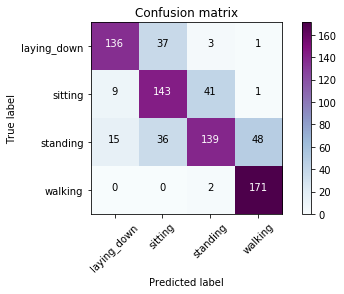

In [108]:
rfAGargs = [rfAGbestTree, rfAGbestFeatures, rfAGbestDepth]
print(rfAGargs)
rfAGAccuracy, rfAGPrecision = fitAndTestModel('RandomForestClassifier', XAGTrain, yAGTrain, XAGTest, yAGTest, rfAGargs, classes)

In [120]:
#random forest classifier
trees = list(range(10, 30))
features = list(range(1, XATest.shape[1] + 1))
depths = list(range(1, 30))
rfAbestAccuracy = 0
rfAbestPrecision = None
rfAbestTree = 0
rfAbestDepth = 0
rfAbestFeatures = 0
rfAbestModel = None

for tree in trees:
    for feature in features:
        for depth in depths:
            rfModel = RandomForestClassifier(n_estimators=tree, max_features=feature, max_depth=depth, oob_score=True, random_state=10)
            rfModel.fit(XATrain, yATrain)
            prediction = rfModel.predict(XATest)
            accuracy = metrics.accuracy_score(yATest, prediction)
            precision = metrics.precision_score(yATest, prediction, average=None)
            
            if accuracy > rfAbestAccuracy:
                rfAbestAccuracy = accuracy
                rfAbestPrecision = precision
                rfAbestTree = tree
                rfAbestDepth = depth
                rfAbestFeatures = feature
                rfAbestModel = rfModel

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

KeyboardInterrupt: 

[10, 45, 4]


c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.7672634271099744
Precision:  [0.8452381  0.66666667 0.77604167 0.82122905]
Confusion Matrix:
[[142  34   1   0]
 [ 15 162  16   1]
 [ 11  47 149  31]
 [  0   0  26 147]]


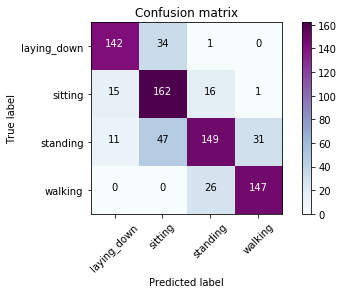

In [121]:
rfAargs = [rfAbestTree, rfAbestFeatures, rfAbestDepth]
print(rfAargs)
rfAAccuracy, rfAPrecision = fitAndTestModel('RandomForestClassifier', XATrain, yATrain, XATest, yATest, rfAargs, classes)

In [124]:
#random forest classifier
trees = list(range(10, 30))
features = list(range(1, XMAGTest.shape[1] + 1))
depths = list(range(1, 45))
rfMAGbestAccuracy = 0
rfMAGbestPrecision = None
rfMAGbestTree = 0
rfMAGbestDepth = 0
rfMAGbestFeatures = 0
rfMAGbestModel = None

for tree in trees:
    for feature in features:
        for depth in depths:
            rfModel = RandomForestClassifier(n_estimators=tree, max_features=feature, max_depth=depth, oob_score=True, random_state=10)
            rfModel.fit(XMAGTrain, yMAGTrain)
            prediction = rfModel.predict(XMAGTest)
            accuracy = metrics.accuracy_score(yMAGTest, prediction)
            precision = metrics.precision_score(yMAGTest, prediction, average=None)
            
            if accuracy > rfMAGbestAccuracy:
                rfMAGbestAccuracy = accuracy
                rfMAGbestPrecision = precision
                rfMAGbestTree = tree
                rfMAGbestDepth = depth
                rfMAGbestFeatures = feature
                rfMAGbestModel = rfModel

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\anoos\appdata\l

KeyboardInterrupt: 

[12, 7, 3]


c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\anoos\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.6317135549872123
Precision:  [0.50352113 0.38053097 0.88815789 0.74248927]
Confusion Matrix:
[[143  27   5   2]
 [137  43  12   2]
 [  4  43 135  56]
 [  0   0   0 173]]


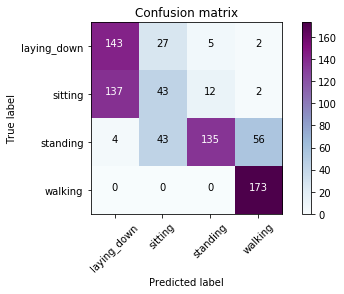

In [125]:
rfMAGargs = [rfMAGbestTree, rfMAGbestFeatures, rfMAGbestDepth]
print(rfMAGargs)
#rfMAGargs = [80, 8, 10]
rfMAGAccuracy, rfMAGPrecision = fitAndTestModel('RandomForestClassifier', XMAGTrain, yMAGTrain, XMAGTest, yMAGTest, rfMAGargs, classes)

Decision Tree

In [33]:
dtAGbestAccuracy, dtAGbestPrecision, dtAGbestFeatures = gridSearchDT(XAGTrain, yAGTrain, XAGTest, yAGTest)

Max Features:  66
Accuracy:  0.7071611253196931
Precision:  [0.84065934 0.65789474 0.59913793 0.74537037]
Confusion Matrix:
[[153  22   2   0]
 [  3 100  88   3]
 [ 26  21 139  52]
 [  0   9   3 161]]


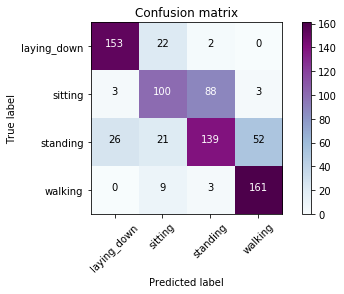

In [70]:
AGargs = [dtAGbestFeatures]
print("Max Features: ",dtAGbestFeatures)
dtAGAccuracy, dtAGPrecision = fitAndTestModel('DecisionTreeClassifier', XAGTrain, yAGTrain, XAGTest, yAGTest, AGargs, classes)

In [35]:
dtAbestAccuracy, dtAbestPrecision, dtAbestFeatures = gridSearchDT(XATrain, yATrain, XATest, yATest)

Max Features: 12
Accuracy:  0.6547314578005116
Precision:  [0.70351759 0.62857143 0.55021834 0.79166667]
Confusion Matrix:
[[140  23  12   2]
 [ 15 132  45   2]
 [ 41  45 126  26]
 [  3  10  46 114]]


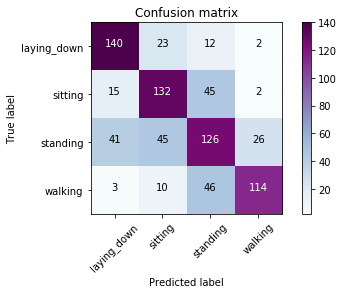

In [71]:
Aargs = [dtAbestFeatures]
print("Max Features:", dtAbestFeatures)
dtAAccuracy, dtAPrecision = fitAndTestModel('DecisionTreeClassifier', XATrain, yATrain, XATest, yATest, Aargs, classes)

In [37]:
dtMAGbestAccuracy, dtMAGbestPrecision, dtMAGbestFeatures = gridSearchDT(XMAGTrain, yMAGTrain, XMAGTest, yMAGTest)

Max Features: 6
Accuracy:  0.592071611253197
Precision:  [0.63070539 0.35135135 0.4806867  0.73931624]
Confusion Matrix:
[[152  14  10   1]
 [ 55  26 111   2]
 [ 34  34 112  58]
 [  0   0   0 173]]


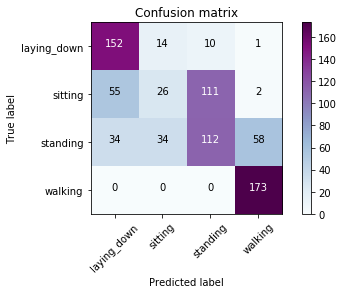

In [72]:
MAGargs = [dtMAGbestFeatures]
print("Max Features:",dtMAGbestFeatures)
dtMAGAccuracy, dtMAGPrecision = fitAndTestModel('DecisionTreeClassifier', XMAGTrain, yMAGTrain, XMAGTest, yMAGTest, MAGargs, classes)

MLP CLassifier

In [109]:
mlpAGbestAccuracy, mlpAGbestPrecision, mlpAGbestActivation, mlpAGbesthLayer1, mlpAGbesthLayer2 = gridSearchMLP(XAGTrain, yAGTrain, XAGTest, yAGTest)

0.6317135549872123
0.7289002557544757
0.5127877237851662
0.7301790281329923
0.5485933503836317
0.7020460358056266
0.6572890025575447
0.6086956521739131
0.6547314578005116
0.782608695652174
0.592071611253197
0.5882352941176471
0.6419437340153452
0.5831202046035806
0.6214833759590793
0.5575447570332481
0.680306905370844
0.6726342710997443
0.4820971867007673
0.7634271099744245
0.612531969309463
0.4936061381074169
0.6867007672634271
0.6930946291560103
0.7340153452685422
0.5907928388746803
0.6560102301790282
0.571611253196931
0.7595907928388747
0.6918158567774936
0.639386189258312
0.6355498721227621
0.5882352941176471
0.6636828644501279
0.7007672634271099
0.612531969309463
0.5831202046035806
0.7071611253196931
0.7135549872122762
0.639386189258312
0.540920716112532
0.7225063938618926
0.6572890025575447
0.6240409207161125
0.6317135549872123
0.7161125319693095
0.6943734015345269
0.618925831202046
0.6994884910485933
0.5741687979539642
0.7046035805626598
0.6521739130434783
0.6074168797953964
0.6

[(10, 100), 'logistic']
Accuracy:  0.782608695652174
Precision:  [0.89240506 0.78421053 0.80978261 0.692     ]
Confusion Matrix:
[[141  32   2   2]
 [ 11 149  33   1]
 [  6   9 149  74]
 [  0   0   0 173]]


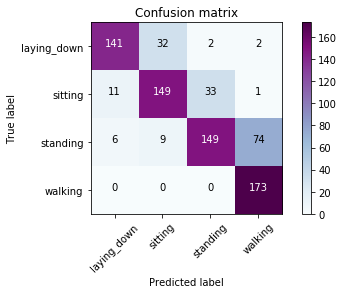

In [110]:
mlpAGargs = [(mlpAGbesthLayer1, mlpAGbesthLayer2), mlpAGbestActivation]
print(mlpAGargs)
mlpAGAccuracy, mlpAGPrecision = fitAndTestModel('MLPClassifier', XAGTrain, yAGTrain, XAGTest, yAGTest, mlpAGargs, classes)

In [111]:
mlpAbestAccuracy, mlpAbestPrecision, mlpAbestActivation, mlpAbesthLayer1, mlpAbesthLayer2 = gridSearchMLP(XATrain, yATrain, XATest, yATest)

0.5626598465473146
0.6726342710997443
0.6086956521739131
0.530690537084399
0.5063938618925832
0.46035805626598464
0.5332480818414322
0.6278772378516624
0.5447570332480819
0.5831202046035806
0.49872122762148335
0.6508951406649617
0.6879795396419437
0.5537084398976982
0.6624040920716112
0.6265984654731458
0.6342710997442456
0.7148337595907929
0.5895140664961637
0.6892583120204604
0.6432225063938619
0.6406649616368286
0.6828644501278772
0.6483375959079284
0.6534526854219949
0.6956521739130435
0.680306905370844
0.6342710997442456
0.6892583120204604
0.6841432225063938
0.6048593350383632
0.659846547314578
0.6751918158567775
0.6841432225063938
0.7122762148337596
0.6278772378516624
0.6726342710997443
0.7084398976982097
0.6841432225063938
0.7340153452685422
0.6355498721227621
0.6675191815856778
0.6675191815856778
0.6790281329923273
0.6445012787723785
0.6918158567774936
0.7352941176470589
0.6240409207161125
0.571611253196931
0.6918158567774936
0.6547314578005116
0.6457800511508951
0.695652173913

[(30, 30), 'tanh']
Accuracy:  0.7570332480818415
Precision:  [0.81333333 0.68627451 0.78846154 0.75454545]
Confusion Matrix:
[[122  51   4   0]
 [ 18 140  34   2]
 [ 10  12 164  52]
 [  0   1   6 166]]


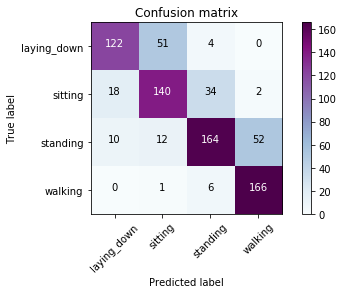

In [113]:
mlpAargs = [(mlpAbesthLayer1, mlpAbesthLayer2), mlpAbestActivation]
print(mlpAargs)
mlpAAccuracy, mlpAPrecision = fitAndTestModel('MLPClassifier', XATrain, yATrain, XATest, yATest, mlpAargs, classes)

In [114]:
mlpMAGbestAccuracy, mlpMAGbestPrecision, mlpMAGbestActivation, mlpMAGbesthLayer1, mlpMAGbesthLayer2 = gridSearchMLP(XMAGTrain, yMAGTrain, XMAGTest, yMAGTest)

0.7148337595907929
0.7058823529411765
0.6163682864450127
0.6470588235294118
0.5639386189258312
0.5959079283887468
0.5281329923273658
0.7007672634271099
0.5946291560102301
0.5869565217391305
0.5242966751918159
0.4936061381074169
0.5498721227621484
0.5959079283887468
0.5843989769820972
0.612531969309463
0.5191815856777494
0.49872122762148335
0.571611253196931
0.5741687979539642
0.5588235294117647
0.48081841432225064
0.5485933503836317
0.571611253196931
0.6317135549872123
0.5933503836317136
0.6176470588235294
0.5434782608695652
0.6240409207161125
0.59846547314578
0.6508951406649617
0.5268542199488491
0.592071611253197
0.6278772378516624
0.6061381074168798
0.578005115089514
0.5754475703324808
0.6061381074168798
0.6368286445012787
0.540920716112532
0.5383631713554987
0.5869565217391305
0.5460358056265985
0.5818414322250639
0.612531969309463
0.49872122762148335
0.6253196930946292
0.5396419437340153
0.540920716112532
0.5089514066496164
0.5933503836317136
0.6381074168797954
0.6176470588235294


[(10, 10), 'logistic']
Accuracy:  0.7148337595907929
Precision:  [0.73958333 0.64397906 0.7202381  0.74891775]
Confusion Matrix:
[[142  26   8   1]
 [ 31 123  39   1]
 [ 19  42 121  56]
 [  0   0   0 173]]


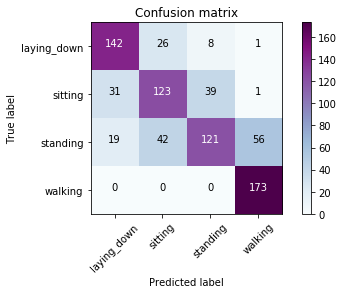

In [115]:
mlpMAGargs = [(mlpMAGbesthLayer1, mlpMAGbesthLayer2), mlpMAGbestActivation]
print(mlpMAGargs)
mlpMAGAccuracy, mlpMAGPrecision = fitAndTestModel('MLPClassifier', XMAGTrain, yMAGTrain, XMAGTest, yMAGTest, mlpMAGargs, classes)

KNeighbors Classifier

In [75]:
kAGbestAccuracy, kAGbestPrecision, kAGbestK = gridSearchKN(XAGTrain, yAGTrain, XAGTest, yAGTest)

Best K: 1
Accuracy:  0.8235294117647058
Precision:  [0.92207792 0.76100629 0.77007299 0.87179487]
Confusion Matrix:
[[142  33   1   1]
 [ 10 121  61   2]
 [  2   3 211  22]
 [  0   2   1 170]]


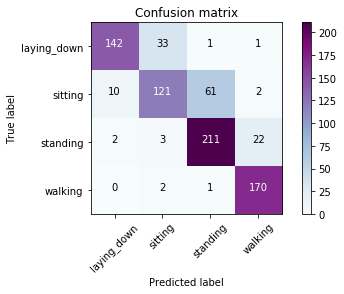

In [77]:
kAGArgs = [kAGbestK]
print("Best K:", kAGbestK)
kAGAccuracy, kAGPrecision = fitAndTestModel('KNeighborsClassifier', XAGTrain, yAGTrain, XAGTest, yAGTest, kAGArgs, classes)

In [78]:
kAbestAccuracy, kAbestPrecision, kAbestK = gridSearchKN(XATrain, yATrain, XATest, yATest)

Best K: 1
Accuracy:  0.8145780051150895
Precision:  [0.9109589  0.73099415 0.76785714 0.88648649]
Confusion Matrix:
[[133  42   2   0]
 [ 11 125  56   2]
 [  2   2 215  19]
 [  0   2   7 164]]


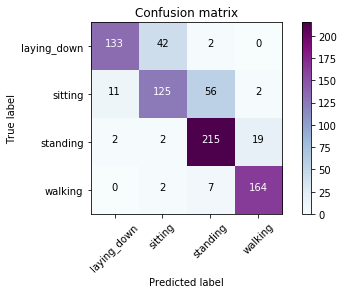

In [79]:
kAArgs = [kAbestK]
print("Best K:", kAbestK)
kAAccuracy, kAPrecision = fitAndTestModel('KNeighborsClassifier', XATrain, yATrain, XATest, yATest, kAArgs, classes)

In [81]:
kMAGbestAccuracy, kMAGbestPrecision, kMAGbestK = gridSearchKN(XMAGTrain, yMAGTrain, XMAGTest, yMAGTest)

Best K: 1
Accuracy:  0.6764705882352942
Precision:  [0.65693431 0.51162791 0.68461538 0.81220657]
Confusion Matrix:
[[ 90  64  19   4]
 [ 37  88  63   6]
 [ 10  20 178  30]
 [  0   0   0 173]]


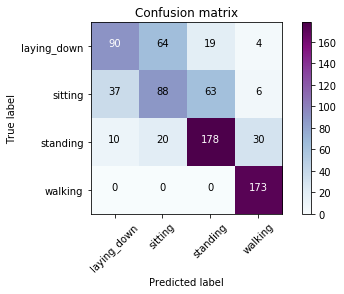

In [82]:
kMAGArgs = [kMAGbestK]
print("Best K:", kMAGbestK)
kMAGAccuracy, kMAGPrecision = fitAndTestModel('KNeighborsClassifier', XMAGTrain, yMAGTrain, XMAGTest, yMAGTest, kMAGArgs, classes)

Logistic Regression

In [84]:
lrAGbestAccuracy, lrAGbestPrecision, lrPenalty = gridSearchLR(XAGTrain, yAGTrain, XAGTest, yAGTest)

Penalty: l2
Accuracy:  0.69693094629156
Precision:  [0.83941606 0.5625     0.66222222 0.75877193]
Confusion Matrix:
[[115  53   8   1]
 [ 17 108  68   1]
 [  5  31 149  53]
 [  0   0   0 173]]


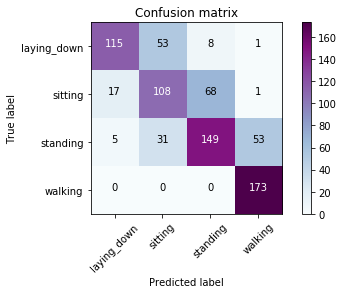

In [85]:
lrAGArgs = [lrPenalty]
print("Penalty:", lrPenalty)
lrAGAccuracy, lrAGPrecision = fitAndTestModel('LogisticRegression', XAGTrain, yAGTrain, XAGTest, yAGTest, lrAGArgs, classes)

In [86]:
lrAbestAccuracy, lrAbestPrecision, lrAPenalty = gridSearchLR(XATrain, yATrain, XATest, yATest)

Penalty: l2
Accuracy:  0.6099744245524297
Precision:  [0.73529412 0.46534653 0.56521739 0.69458128]
Confusion Matrix:
[[125  49   2   1]
 [ 42  94  57   1]
 [  2  59 117  60]
 [  1   0  31 141]]


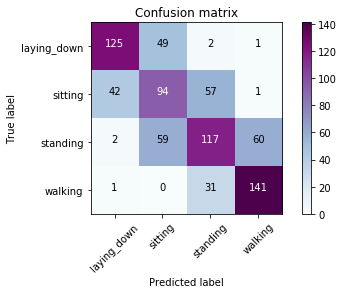

In [87]:
lrAArgs = [lrAPenalty]
print("Penalty:", lrAPenalty)
lrAAccuracy, lrAPrecision = fitAndTestModel('LogisticRegression', XATrain, yATrain, XATest, yATest, lrAArgs, classes)

In [88]:
lrMAGbestAccuracy, lrMAGbestPrecision, lrMAGPenalty = gridSearchLR(XMAGTrain, yMAGTrain, XMAGTest, yMAGTest)

Penalty: l1
Accuracy:  0.629156010230179
Precision:  [0.59447005 0.43452381 0.74050633 0.72384937]
Confusion Matrix:
[[129  38   8   2]
 [ 86  73  33   2]
 [  2  57 117  62]
 [  0   0   0 173]]


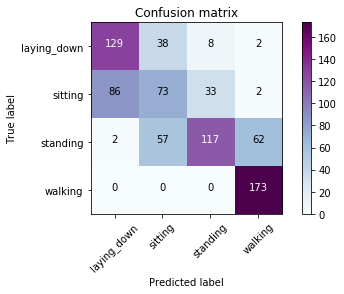

In [90]:
lrMAGArgs = [lrMAGPenalty]
print("Penalty:", lrMAGPenalty)
lrMAGAccuracy, lrMAGPrecision = fitAndTestModel('LogisticRegression', XMAGTrain, yMAGTrain, XMAGTest, yMAGTest, lrMAGArgs, classes)

Support Vector Machine Classifier

In [95]:
svcAGbestAccuracy, svcAGbestPrecision, svcAGC = gridSearchSVC(XAGTrain, yAGTrain, XAGTest, yAGTest)

1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951


C: 351
Accuracy:  0.7186700767263428
Precision:  [0.75294118 0.61437908 0.70464135 0.77927928]
Confusion Matrix:
[[128  48   0   1]
 [ 28  94  70   2]
 [ 14  11 167  46]
 [  0   0   0 173]]


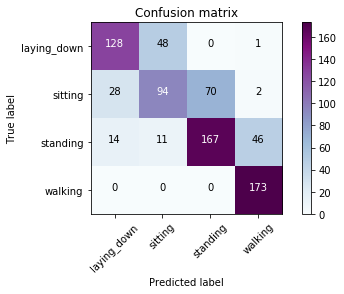

In [96]:
svcAGArgs = [svcAGC]
print("C:", svcAGC)
svcAGAccuracy, svcAGPrecision = fitAndTestModel('SVC', XAGTrain, yAGTrain, XAGTest, yAGTest, svcAGArgs, classes)

In [98]:
svcAbestAccuracy, svcAbestPrecision, svcAC = gridSearchSVC(XATrain, yATrain, XATest, yATest)

C: 551
Accuracy:  0.7199488491048593
Precision:  [0.7983871  0.55744681 0.73221757 0.85869565]
Confusion Matrix:
[[ 99  76   2   0]
 [ 14 131  48   1]
 [ 11  27 175  25]
 [  0   1  14 158]]


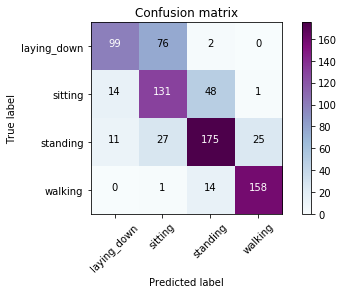

In [99]:
svcAArgs = [svcAC]
print("C:", svcAC)
svcAAccuracy, svcAPrecision = fitAndTestModel('SVC', XATrain, yATrain, XATest, yATest, svcAArgs, classes)

In [102]:
svcMAGbestAccuracy, svcMAGbestPrecision, svcMAGC = gridSearchSVC(XMAGTrain, yMAGTrain, XMAGTest, yMAGTest)

C: 1
Accuracy:  0.6572890025575447
Precision:  [0.71232877 0.44404332 0.73617021 0.84263959]
Confusion Matrix:
[[ 52 125   0   0]
 [ 14 123  56   1]
 [  7  28 173  30]
 [  0   1   6 166]]


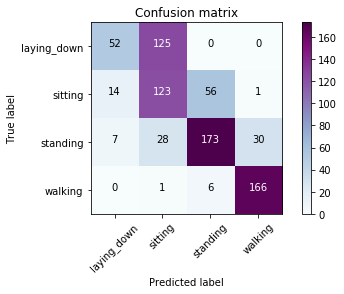

In [103]:
svcMAGArgs = [svcMAGC]
print("C:", svcMAGC)
svcMAGAccuracy, svcMAGPrecision = fitAndTestModel('SVC', XATrain, yATrain, XATest, yATest, svcMAGArgs, classes)

In [119]:
#windowing parameters
trimCutoff = 10
windowSize = 8
overlapping = True
overlappingFactor = 0.5
trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"

In [74]:
#windowing parameters
trimCutoff = 5
windowSize = 4
overlapping = True
overlappingFactor = 0.5
trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"

In [61]:
#windowing parameters
trimCutoff = 10
windowSize = 8
overlapping = False
overlappingFactor = 0
trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"

In [63]:
#windowing parameters
trimCutoff = 5
windowSize = 4
overlapping = False
overlappingFactor = 0
trainDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\finalTrainingData"
testDir = "E:\\UCLA\\CourseWork\\Winter2018\\CS205\\DecentLogger\\TestingData"